# SaxaVord EO Challenge

Welcome to your challenge: Focussing on an Area of Interest (AOI) over the Faroe Islands, you can look at either: 

* Quantify the extent of algae bloom changes, and their impact on nearby Salmon Fishing Farms
* Quantify the extent of recent coastal erosion 

## Check Environment Active

In [ ]:
# Desktop UI:
# It should also show this on the top RHS of your screen, below the LogOut button

In [1]:
# Conda
#  -- Activate environment will show a '*' next to it
!conda env list

# conda environments:
#
base                     /Users/taracunningham/miniconda3
acolite                  /Users/taracunningham/miniconda3/envs/acolite
convml-tt                /Users/taracunningham/miniconda3/envs/convml-tt
cv                       /Users/taracunningham/miniconda3/envs/cv
detectron2               /Users/taracunningham/miniconda3/envs/detectron2
kenya                 *  /Users/taracunningham/miniconda3/envs/kenya
munromap                 /Users/taracunningham/miniconda3/envs/munromap
oosa                     /Users/taracunningham/miniconda3/envs/oosa
pyenv                    /Users/taracunningham/miniconda3/envs/pyenv
sense-abm                /Users/taracunningham/miniconda3/envs/sense-abm
sense2020                /Users/taracunningham/miniconda3/envs/sense2020
sensecdt_env             /Users/taracunningham/miniconda3/envs/sensecdt_env
snap-py36                /Users/taracunningham/miniconda3/envs/snap-py36
tigis                    /Users/taracunningham/miniconda3/env

In [ ]:
# Pip
# TODO: Add this for pip !pip XYZ

## Import Packages

In [11]:
# Packages
import os
import glob

import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile


In [12]:
# Visualisation Params
%matplotlib inline    # plots images in the Jupyter notebook cells
%matplotlib qt5       # opens a seperate browser window to view images

UsageError: unrecognized arguments: # plots images in the Jupyter notebook cells


# Sentinel 2

### The Data Folder Structure
Satellite imagery products are folders which contain satellite imagery data in a standardised way, including standard naming conventions for folders etc. Please see the SaxaVord PDF for an explanation of the Sentinel 2 naming convention. 

A single image  product of a region at DateTime YYYYMMDD-HHMMSS is packaged in a folder with a hierarchical file structure. In our case this is:

    |- S2A_MSIL2A_20220531T120411_N0400_R066_T30VUQ_20220531T183212 *folder for a single day-time image product*
        |-S2A_MSIL2A_20220531T120411_N0400_R066_T30VUQ_20220531T183212.SAFE
            |-GRANULE
                |-L2A_T30VUQ_A036242_20220531T120405
                    |-IMG_DATA
                        |- R10m  *resolution folders*
                            |-T30VUQ_20220531T120411_B02_10m.jp2 *individual band file*
                            |-T30VUQ_20220531T120411_B03_10m.jp2
                            |-...
                            |-T30VUQ_20220531T120411_TCI_10m.jp2 *TCI = true color image, multi-band file *

                        |- R20m
                            |-T30VUQ_20220531T120411_B02_20m.jp2
                            |-T30VUQ_20220531T120411_B03_20m.jp2
                            |-...
                        |- R60m
                            |-T30VUQ_20220531T120411_B02_60m.jp2
                            |-T30VUQ_20220531T120411_B03_60m.jp2
                            |-...


### Image Bands
* True Colour Images (RGB) are comprised of 3 bands, Red, Green and Blue - the visible light section of the Electromagnetic Spectrum. 

* Satellite sensors cover a far broader section of this spectrum, and therefore capture a larger number of bands. 

* Different phenomena on earth and within the atmosphere react differently to wavelengths across the spectrum (e.g. different bands), allowing us to make inferences about what is occuring below.

* Certain bands are therefore useful for different environmental analyses.

* Below is a table of the bands that Sentinel 2 collects, their resolutions and descriptions (from https://gisgeography.com/sentinel-2-bands-combinations/).

* More information about how the data is collected and the different bands can be found in the [Sentinel 2 user guide](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi) on the European Space Agency website.

|Band | Resolution | Central wavelength | Description |
|-----|------------|--------------------|-------------|
|B1	  |60 m	       |443 nm	            |Ultra Blue (Coastal and Aerosol)|
|B2	  |10 m	       |490 nm	            |Blue|
|B3	  |10 m	       |560 nm	            |Green|
|B4	  |10 m	       |665 nm	            |Red|
|B5	  |20 m	       |705 nm	            |Visible and Near Infrared (VNIR)|
|B6	  |20 m	       |740 nm	            |Visible and Near Infrared (VNIR)|
|B7	  |20 m	       |783 nm	            |Visible and Near Infrared (VNIR)|
|B8	  |10 m	       |842 nm	            |Visible and Near Infrared (VNIR)|
|B8a  |20 m	       |865 nm	            |Visible and Near Infrared (VNIR)|
|B9	  |60 m	       |940 nm	            |Short Wave Infrared (SWIR)|
|B10  |60 m	       |1375 nm             |Short Wave Infrared (SWIR)|
|B11  |20 m	       |1610 nm             |Short Wave Infrared (SWIR)|
|B12  |20 m	       |2190 nm             |Short Wave Infrared (SWIR)|


### Working with This Data
For our data we have:
* Images for a set of dates throughout time
* Each image has multiple bands in multiple resolutions
* The filepath for each band is going to be very verbose and difficult to track due to the hierarchical structure

To make all these paths easier to work with, we shall give each Image into it's own dictionary and store all filepaths there. This will enable easy referencing. The code below creates these dictionaries for you.

```
img_band_dict = {
                'img_folder': 'S2A_MSIL2A_20220531T120411_N0400_R066_T30VUQ_20220531T183212',

                 'img_date': '20220531',
                 'img_time': '183212',
                 
                 'R10m':{'B02': 'T30VUQ_20220531T120411_B02_10m.jp2',
                         'B03': 'T30VUQ_20220531T120411_B03_10m.jp2',
                         ...
                         'TCI': 'T30VUQ_20220531T120411_TCI_10m.jp2'
                        },
                        
                  'R20m':{'B02': 'T30VUQ_20220531T120411_B02_20m.jp2',
                          'B03': 'T30VUQ_20220531T120411_B03_20m.jp2',
                           ...
                          },
                          
                  'R60m':{'B02': 'T30VUQ_20220531T120411_B02_60m.jp2',
                          'B03': 'T30VUQ_20220531T120411_B03_60m.jp2',
                           ...
                          }
                 }
                 
```
                 

**For Example:** To create a True Colour Image (RGB) at 10m resolution, we use Red (B04), Green (B03), Blue (B02). The individual bands can then be accessed:

```
## 10m resolution:
r_10m_filepath = img_band_dict['R10m']['B04']
r_10m_band_img = get_band(r_10m_filepath)

g_10m_filepath = img_band_dict['R10m']['B03']
g_10m_band_img = get_band(g_10m_filepath)

b_10m_filepath = img_band_dict['R10m']['B02']
b_10m_band_img = get_band(b_10m_filepath)
```

## Zipped Image Folders: Rename & Extract All Data

In [13]:
# Function to extract source folder.zip to targer folder
def extract_from_zip(source, target):
    with ZipFile(source, 'r') as zip_ref:
        zip_ref.extractall(target)     

In [14]:
# Path from notebook to folder containing zipped folder for each day's data
s2_imgs_folder = 'Faroe Islands Satellite Data'

# Select your joiner 
# MAC 
jn = '/'

# WINDOWS
jn = '\\'


# Windows: Zip Folder names may be too long upon extraction, shorten names by removing characters from name from '_N0400' onwards
for file_name in os.listdir(s2_imgs_folder):
    file = ''
    file = s2_imgs_folder + jn + file_name #TODO: switch '\\' to '/' for Mac
    
    # Only perform operation of zipped folders
    if file.endswith('.zip'):
        t = '_N0400'
        ind = file.find(t)
        
        # Renaming required
        if ind>=0:    
            file_new = file[:ind] + '.zip'
            os.rename(file, file_new)

        # No renaming required
        else:
            file_new = file
            
        # Extract all files from .zip
        file_new_unzip = file_new[:-4]
        extract_from_zip(file_new, file_new_unzip)
        
             
# Check name shortened, and folders unzipped correctly        
os.listdir(s2_imgs_folder)

['S2A_MSIL2A_20220531T120411',
 'S2A_MSIL2A_20220531T120411.zip',
 'S2A_MSIL2A_20220607T115411',
 'S2A_MSIL2A_20220607T115411.zip',
 'S2B_MSIL2A_20220327T120359',
 'S2B_MSIL2A_20220327T120359.zip',
 'S2B_MSIL2A_20220419T121349',
 'S2B_MSIL2A_20220419T121349.zip',
 'S2B_MSIL2A_20220705T120359',
 'S2B_MSIL2A_20220705T120359.zip',
 'S2B_MSIL2A_20220831T115359',
 'S2B_MSIL2A_20220831T115359.zip']

## Create Dictionaries of Band File Paths

In [13]:
# Using new directory structure and .SAFE extension as the selector

# set directory with Sentinel 2 data
sen2dir = './starter_data/sentinel2/'

# get list of image directories
lst = os.listdir(sen2dir)
img_dirs_lst = [x for x in lst if x.endswith('.SAFE')]

print(img_dirs_lst)

['S2B_MSIL2A_20220705T120359_N0400_R066_T30VUQ_20220705T160213.SAFE', 'S2B_MSIL2A_20220327T120359_N0400_R066_T29VPK_20220327T163425.SAFE', 'S2A_MSIL2A_20220531T120411_N0400_R066_T30VUQ_20220531T183212.SAFE', 'S2B_MSIL2A_20220831T115359_N0400_R023_T29VPK_20220831T141847.SAFE', 'S2A_MSIL2A_20220607T115411_N0400_R023_T29VPK_20220607T182818.SAFE', 'S2B_MSIL2A_20220419T121349_N0400_R109_T29VPK_20220419T150207.SAFE']


In [14]:
# For each unzipped folder (a single day product), go in & extract all '.jp2' filepaths for the bands into a dictionary
# Store all dictionaries in a list (all_img_dicts)

all_img_dicts = []
jn = '/'

#for img_folder in unzipped_img_folders:
for img_folder in img_dirs_lst:

    ## List all band filenames
    # img_folder = 'S2B_MSIL2A_20220419T121349'
    date = img_folder[11:19]
    time = img_folder[20:26]
    f = sen2dir + jn + img_folder + jn
    #f = s2_imgs_folder + jn + img_folder + jn

    # Sub-folders containing band data
    res_set = ['R10m', 'R20m', 'R60m']

    # Create a dictionary of the band names
    bands = ['B01','B02','B03','B04','B05','B06', 'B07','B08', 'B8A', 'B09' ,'B10','B11','B12', 'AOT','TCI','WVP', 'SCL']

    all_band_files = [ x for x in glob.glob(f + '**' + jn + '*', recursive=True) if any(res in x for res in res_set) and x.endswith('jp2')]


    img_band_dict = {'img_folder':img_folder,
                     'img_date':date,
                     'img_time':time}

    # Create a key for each resolution
    for res in res_set:
        img_band_dict[res] = {}

    # Assign all band filepaths to dict
    for band_file in all_band_files:

        # For each resolution, get all band filepaths
        for res in res_set:

            # Band file is in the resolution folder (contains res = 'R10m')
            if band_file.find(res)>=0:

                # Get the band type (B08, B8A, TCI etc)
                band_type = band_file[len(band_file)-11:-8]

                # Store e.g. img_band_dict['R10m']['B03'] = 'filepath/to/R10m/img_B03.jp2'
                img_band_dict[res][band_type] = band_file
                
    
    all_img_dicts.append(img_band_dict)
            

In [15]:
all_img_dicts[0]

{'img_folder': 'S2B_MSIL2A_20220705T120359_N0400_R066_T30VUQ_20220705T160213.SAFE',
 'img_date': '20220705',
 'img_time': '120359',
 'R10m': {'B04': './starter_data/sentinel2//S2B_MSIL2A_20220705T120359_N0400_R066_T30VUQ_20220705T160213.SAFE/GRANULE/L2A_T30VUQ_A027834_20220705T120402/IMG_DATA/R10m/T30VUQ_20220705T120359_B04_10m.jp2',
  'AOT': './starter_data/sentinel2//S2B_MSIL2A_20220705T120359_N0400_R066_T30VUQ_20220705T160213.SAFE/GRANULE/L2A_T30VUQ_A027834_20220705T120402/IMG_DATA/R10m/T30VUQ_20220705T120359_AOT_10m.jp2',
  'TCI': './starter_data/sentinel2//S2B_MSIL2A_20220705T120359_N0400_R066_T30VUQ_20220705T160213.SAFE/GRANULE/L2A_T30VUQ_A027834_20220705T120402/IMG_DATA/R10m/T30VUQ_20220705T120359_TCI_10m.jp2',
  'WVP': './starter_data/sentinel2//S2B_MSIL2A_20220705T120359_N0400_R066_T30VUQ_20220705T160213.SAFE/GRANULE/L2A_T30VUQ_A027834_20220705T120402/IMG_DATA/R10m/T30VUQ_20220705T120359_WVP_10m.jp2',
  'B03': './starter_data/sentinel2//S2B_MSIL2A_20220705T120359_N0400_R066_T3

In [17]:
# Access a dictionary of a single image
img_day_dict = all_img_dicts[0]

print('date:',img_day_dict['img_date'])
print('time:',img_day_dict['img_time'])

print('path to 20m B05 Band (Red Edge):')
print('   ', img_day_dict['R20m']['B05'])

date: 20220705
time: 120359
path to 20m B05 Band (Red Edge):
    ./starter_data/sentinel2//S2B_MSIL2A_20220705T120359_N0400_R066_T30VUQ_20220705T160213.SAFE/GRANULE/L2A_T30VUQ_A027834_20220705T120402/IMG_DATA/R20m/T30VUQ_20220705T120359_B05_20m.jp2


In [ ]:
## See which bands available at which resolution

print('R10m:',img_day_dict['R10m'].keys())
print('R20m:',img_day_dict['R20m'].keys())
print('R60m:',img_day_dict['R60m'].keys())

## Import Band Data and Pre-processing

The single band files (B02, B03, B04,...) are 2D rasters. These are 2D numpy arrays with some associated metadata. 
The composite band files e.g. TCI are 3D rasters. We will use Masked numpy arrays on which you can use most of the same numpy methods.

To handle rasters, we use the **rasterio** (rio) package which is built on top of numpy specifically for geographical data.

Note that, unlike normal numpy arrays, rasterio takes the top Left Hand Side of your array as (0,0), then x is the rows downwards, and y is the columns right.

The [rasterio documentation](https://rasterio.readthedocs.io/en/latest/) is pretty good and provides lots of examples for common geospatial operations.

First, let's load a single band into an array.

In [ ]:
## Perform calcs

In [18]:
## Extract Single Band into an Array

def get_band(filepath): 
    with rio.open(filepath) as f:
        img = f.read(1, masked=True)
        metadata = f.profile
        
        return img, metadata

def print_band_properties(image, metadata):
    print('--> # bands:', metadata['count'])
    print('--> array type', type(image))
    print('--> datatype:', metadata['dtype'])
    print('--> nodata value:', metadata['nodata'])
    print('--> height:', metadata['height'], 'pixels')
    print('--> width:', metadata['width'], 'pixels')
    print('--> CRS:', metadata['crs'])
    print(20*'-')

    
# load example images and metadata and display properties to investigate

# single band image
b02_img, b02_metadata = get_band(img_day_dict['R10m']['B02'])
print('b02 properties:')
print_band_properties(b02_img, b02_metadata)

# True Colour Image (TCI) with 3 bands
tci_img, tci_metadata = get_band(img_day_dict['R10m']['TCI'])
print('TCI properties:')
print_band_properties(tci_img, tci_metadata)


print(f'\nMin:\t{b02_img.min()}\nMax:\t{b02_img.max()}\nMean:\t{b02_img.mean():.2f}\nStdDev:\t{b02_img.std():.2f}\n')

b02_img

b02 properties:
--> # bands: 1
--> array type <class 'numpy.ma.core.MaskedArray'>
--> datatype: uint16
--> nodata value: None
--> height: 10980 pixels
--> width: 10980 pixels
--> CRS: EPSG:32630
--------------------
TCI properties:
--> # bands: 3
--> array type <class 'numpy.ma.core.MaskedArray'>
--> datatype: uint8
--> nodata value: None
--> height: 10980 pixels
--> width: 10980 pixels
--> CRS: EPSG:32630
--------------------

Min:	0
Max:	18848
Mean:	683.60
StdDev:	1541.65



masked_array(
  data=[[   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        ...,
        [1746, 1756, 1730, ..., 1287, 1256, 1254],
        [1810, 1732, 1700, ..., 1368, 1300, 1239],
        [1730, 1766, 1742, ..., 1375, 1316, 1290]],
  mask=False,
  fill_value=999999,
  dtype=uint16)

We have imported the image as a masked array, but currently the mask isn't doing very much and simply says "False". Instead we would like the portions of the image where we don't have data to be masked out so they are not included in any calculations we do on the raster.

For Sentinel 2, 0 is is reserved for nodata, therefore we will mask all the zeroes so they are not included in any calculations we do on the rasters.

The raster is instead 'filled' with a 'fill_value' set to a large negative number, '-9999' and the corresponding metadata 'nodata' value is updated. This will tell rasterio there is no data at these locations when the raster is written to file.

In order to do this we first need to update the datatype to enable the raster to store negative numbers. We will also update the metadata to match as we go along.

**NB** mask == True if the data **is** masked.

In [19]:
def update_raster_dtype(raster, metadata, new_dtype='int16'):
    
    old_dtype = raster.dtype
    
    raster = raster.astype(new_dtype)
    metadata.update({
            "dtype": f'{new_dtype}'
        })
    
    print('Raster datatype has been updated from ', old_dtype, 'to ', raster.dtype)
    print('Metadata dtype has been updated to:', metadata['dtype'])
    
    return raster, metadata

def update_sen2_mask(raster, metadata):
    
    # update datatype for image and metadata
    raster, metadata = update_raster_dtype(raster, metadata)
    
    # update mask, fill value and metadata
    raster = np.ma.MaskedArray(raster, mask=(raster==0), fill_value=-9999)
    metadata['nodata'] = -9999

    print('Metadata nodata value has been updated to:', metadata['nodata'])
    
    return raster, metadata


tci_img, tci_metadata = update_sen2_mask(tci_img, tci_metadata)
b02_img, b02_metadata = update_sen2_mask(b02_img, b02_metadata)

print(f'\nMin:\t{b02_img.min()}\nMax:\t{b02_img.max()}\nMean:\t{b02_img.mean():.2f}\nStdDev:\t{b02_img.std():.2f}\n')

tci_img

Raster datatype has been updated from  uint8 to  int16
Metadata dtype has been updated to: int16
Metadata nodata value has been updated to: -9999
Raster datatype has been updated from  uint16 to  int16
Metadata dtype has been updated to: int16
Metadata nodata value has been updated to: -9999

Min:	1
Max:	18848
Mean:	2133.13
StdDev:	2079.50



masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [86, 92, 90, ..., 20, 16, 15],
        [91, 90, 86, ..., 22, 19, 16],
        [73, 83, 80, ..., 19, 24, 20]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=-9999,
  dtype=int16)

Note that we can access the data and mask separately with the syntax below.

In [120]:
print('b02 data:\n', b02_img.data)
print('b02 mask:\n', b02_img.mask)

b02 data:
 [[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [1746 1756 1730 ... 1287 1256 1254]
 [1810 1732 1700 ... 1368 1300 1239]
 [1730 1766 1742 ... 1375 1316 1290]]
b02 mask:
 [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


## Inspect and Plot data

We will load an RGB composite to show some data inspection and plotting methods.

To have a quick look in RGB at a tile we can load the TCI file from each Sentinel image and plot it using the `rasterio.plot show()` method. Note that TCI raster is on the interval (0, 255), where 0 means nodata, unlike the individual band data.

In [20]:
from rasterio.plot import show

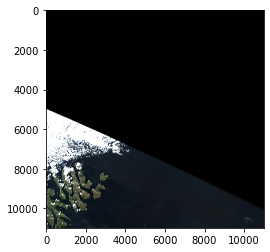

<AxesSubplot:>

In [130]:
with rio.open(img_day_dict['R10m']['TCI']) as f:
    rgb_img = f.read([1, 2, 3], masked=True)

show(rgb_img)

To create other composites, we can read in the bands separately. For example, a false colour composite uses B8, B4 and B3.

In [43]:
# read in B03 (green), B04 (red) and B08 (near-infrared)
b03, b03_metadata = get_band(img_day_dict['R10m']['B03'])
b04, b04_metadata = get_band(img_day_dict['R10m']['B04'])
b08, b08_metadata = get_band(img_day_dict['R10m']['B08'])

# mask
b03, b03_metadata = update_sen2_mask(b03, b03_metadata)
b04, b04_metadata = update_sen2_mask(b04, b04_metadata)
b08, b08_metadata = update_sen2_mask(b08, b08_metadata)

Raster datatype has been updated from  uint16 to  int16
Metadata dtype has been updated to: int16
Metadata nodata value has been updated to: -9999
Raster datatype has been updated from  uint16 to  int16
Metadata dtype has been updated to: int16
Metadata nodata value has been updated to: -9999
Raster datatype has been updated from  uint16 to  int16
Metadata dtype has been updated to: int16
Metadata nodata value has been updated to: -9999


As matplotlib can only deal with data in the uint8 range (0, 255), or data on the interval [0, 1], we will divide the data by 10000 and normalise it to the [0, 1] interval as preparation for plotting. We can also clip the data to the mean ± 2 standard deviations for nice plotting. You can change the clip parameter to False to see the difference.

In [21]:
def normalise_band(raster, clip=True):
    
    raster = raster / 10000
    
    if clip is True:
        
        mn = raster.mean()
        sd = raster.std()
        upper = mn + (2*sd)
        lower = mn - (2*sd)
    
        raster[raster > upper] = upper
        raster[raster < lower] = lower
    
    return (raster - raster.min()) / (raster.max() - raster.min())

To plot the false colour composite, we can stack the images using `np.stack` so that rasterio.plot's show() method will plot all three bands. The stack must be in the correct band order to display correctly.
Here we have:
1. red channel -> B08
2. green channel -> B04
3. blue channel -> B03

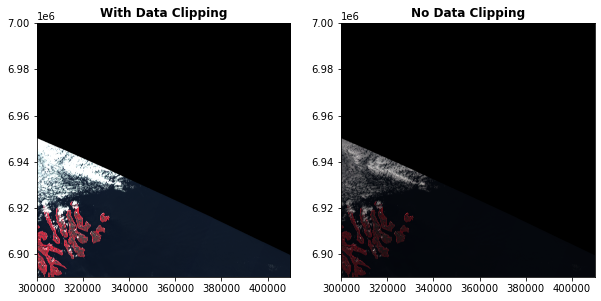

In [135]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

# stack rasters for plotting
stack1 = np.stack([normalise_band(b08), normalise_band(b04), normalise_band(b03)])
stack2 = np.stack([normalise_band(b08, clip=False), normalise_band(b04, clip=False), normalise_band(b03, clip=False)])

show(stack1, transform=b08_metadata['transform'], ax=ax1, title="With Data Clipping")
show(stack2, transform=b08_metadata['transform'], ax=ax2, title="No Data Clipping")

ax_image.set_title('S2 False Colour Composite Comparison', fontsize=20)

plt.show()

### Histograms

We can also use basic numpy statistics methods to look at the data. This is a good way to check that the mask is working and not using the original nodata zeroes.

In [110]:
print(f'\nMin:\t{b02_img_norm.min()}\nMax:\t{b02_img_norm.max()}\nMean:\t{b02_img_norm.mean():.3f}\nStdDev:\t{b02_img_norm.std():.3f}\n')


Min:	0.0
Max:	1.0
Mean:	0.31
StdDev:	0.24



A histogram of the data can be plotted for inspection using the matplotlib hist method, or rasterio's built-in historgram plotter, show-hist.

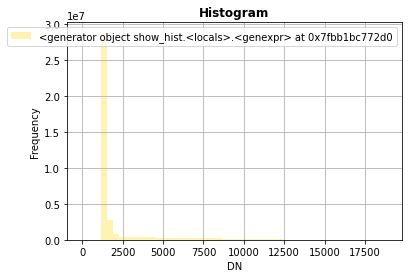

In [97]:
from rasterio.plot import show_hist

show_hist(
    b03_img, bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram")

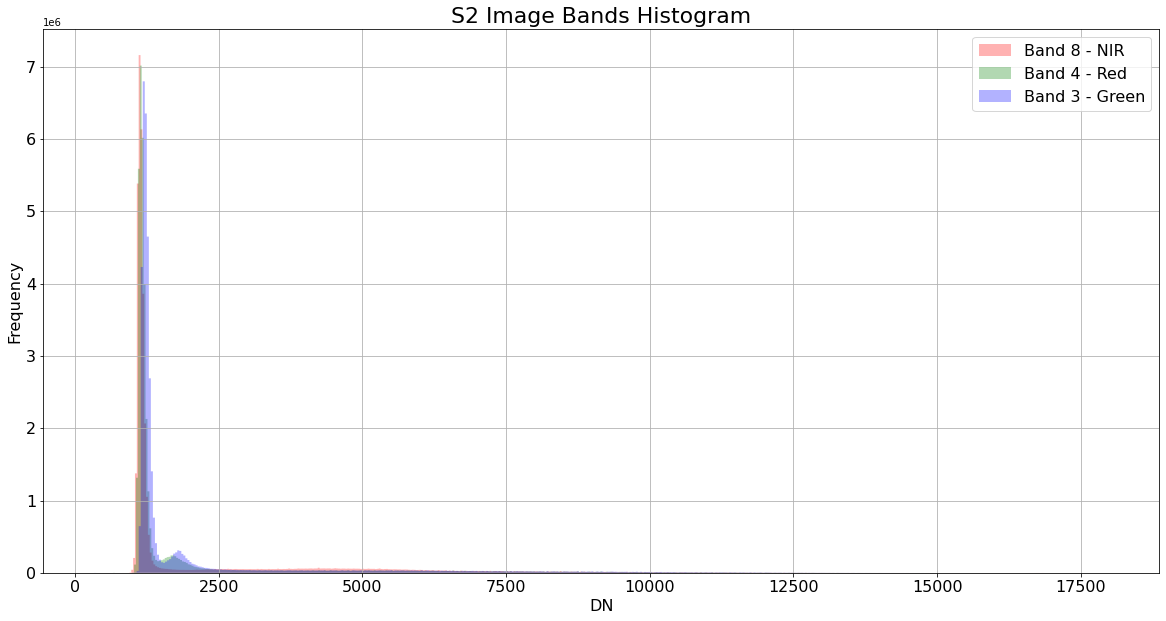

In [136]:
from matplotlib import pyplot as plt

fig, ax_histogram = plt.subplots(figsize=(20, 10))

ax_histogram.hist(b08.ravel(), bins=500, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, color='Red', label='Band 8 - NIR')
ax_histogram.hist(b04.ravel(), bins=500, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, color='Green', label='Band 4 - Red')
ax_histogram.hist(b03.ravel(), bins=500, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, color='Blue', label='Band 3 - Green')

ax_histogram.tick_params(axis='both', which='major', labelsize=16)
ax_histogram.set_xlabel('DN', fontsize=16)
ax_histogram.set_ylabel('Frequency', fontsize=16)
ax_histogram.set_title('S2 Image Bands Histogram', fontsize=22)

plt.legend(fontsize=16)
plt.grid()
plt.show()

## Resampling - Changing the Spatial Resolution of a Band

Resampling is a common task in geospatial analysis, because in order to do direct calculations between different bands, they must be the same spatial resolution, i.e. the size of a pixel mapped onto the surface of the Earth must be the same.

As a reminder, Sentinel 2 bands have the following resolution:

**10m : Bands 2, 3, 4, 8**

**20m : Bands 5, 6, 7, 8A, 11, 12**

**60m : Bands 1, 9, 10**

The following code will upsample or downsample the resolution of a raster based on a scaling factor.

A scale factor > 1 will increase the resolution of the raster. To do this we have to interpolate between existing data values in the raster. Rasterio includes a Resampling method for this purpose with various interpolation methods. We will use bilinear interpolation here. The code below is predominantly from the [rasterio documentation](https://rasterio.readthedocs.io/en/latest/topics/resampling.html).

Before resampling, the spatial resolution is 20.0 metres

After resampling, the spatial resolution is 10.0 metres



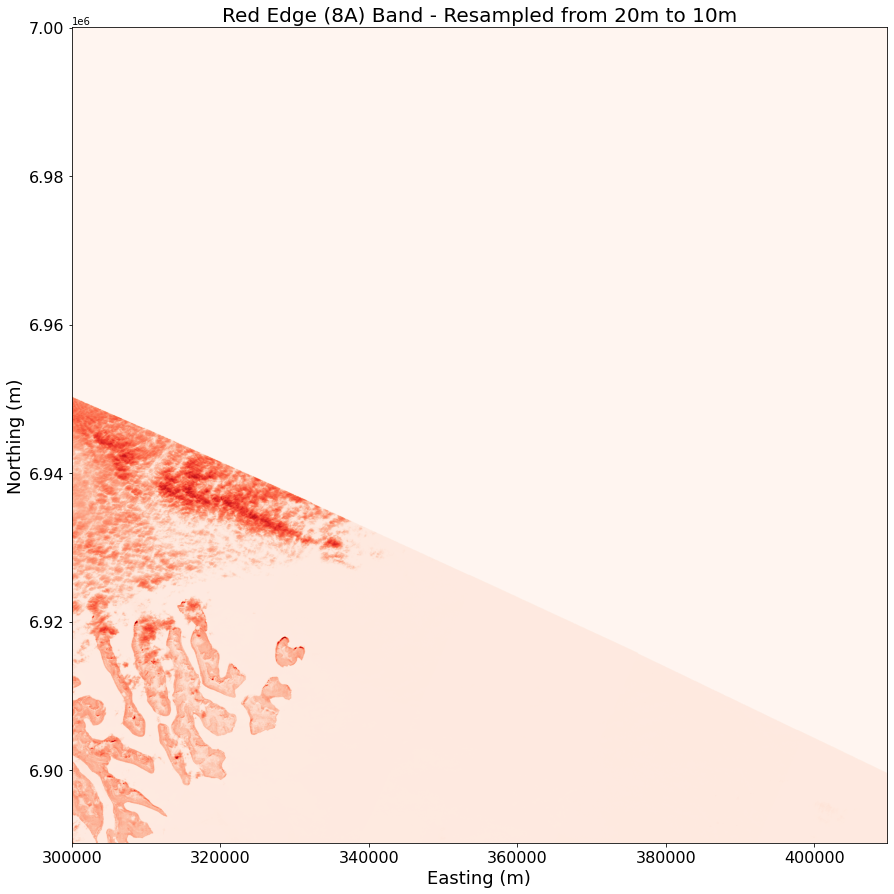

In [138]:
from rasterio.enums import Resampling

fig, ax = plt.subplots(figsize=(15, 15))

scale_factor = 2 # double spatial resolution

with rio.open(img_day_dict['R20m']['B8A']) as dataset:

    print(f'Before resampling, the spatial resolution is {dataset.res[0]} metres\n')
    
    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * scale_factor),
            int(dataset.width * scale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

    
print(f'After resampling, the spatial resolution is {dataset.res[0] / scale_factor} metres\n')
show(data, transform=transform, ax=ax, cmap='Reds')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('Easting (m)', fontsize=18)
ax.set_ylabel('Northing (m)', fontsize=18)
ax.set_title('Red Edge (8A) Band - Resampled from 20m to 10m', fontsize=20)

plt.show()

## Calculations: Band Maths, Indices and Thresholding

Now that we know how to load bands from file into a numpy array, resample them, and plot them, we can use band maths to combine the bands in various ways and infer properties on the ground. Band maths consist of simply performing arithmetic operations to combine numpy arrays.

Some common indices you might consider for your analysis include:

* Normalised Difference Vegetation Index (NDVI) 
    - (B8 - B4) / (B8 + B4)
    - Used for mapping vegetation because vegetation reflects strongly in the near IR (B8) and is strongly absorbed in red (B4)
    
* Normalised Difference Water Index
    - (B3 - B8) / (B3 + B8)
    - Used to detect water.

* Bare Soil Index (BSI)
    - ((B11 + B4) - (B8 + B2)) / ((B11 + B4) - (B8 + B2))
    - Used to detect bare ground, for example in crop monitoring, or landslide monitoring such as visualised in [this script[(https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/barren_soil/#).
    
More indices [here](https://giscrack.com/list-of-spectral-indices-for-sentinel-and-landsat/).

Below is an example calculation for NDVI.

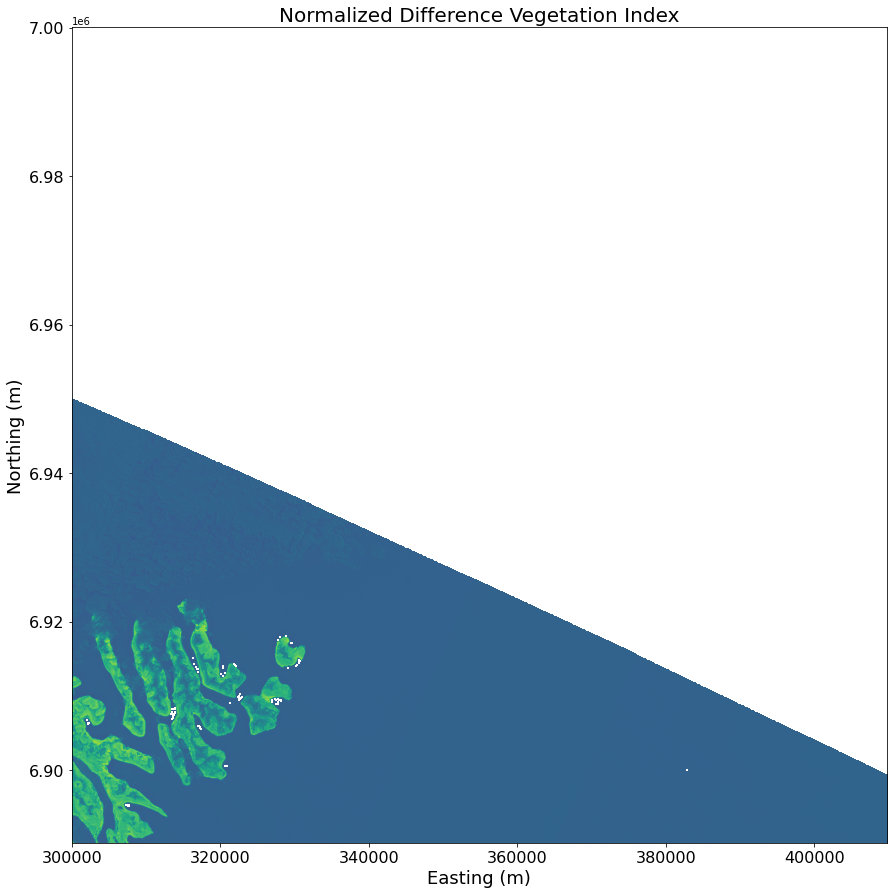

In [145]:
# Normlise bands before calculation
b08_norm = normalise_band(b08)
b04_norm = normalise_band(b04)

# Calculate NDVI
ndvi = np.divide(np.subtract(b08, b04), np.add(b08, b04))

# Plot
fig, ax_ndvi = plt.subplots(figsize=(15, 15))

show(ndvi, transform=b04_metadata['transform'], ax=ax_ndvi)

ax_ndvi.tick_params(axis='both', which='major', labelsize=16)
ax_ndvi.set_title('Normalized Difference Vegetation Index', fontsize=20)

plt.show()

**Notice above:** For RGB, integer pixel values take values [0,255], yet above its far higher. Why?

* **Traditional RGB pixels have 8-Bit Depth:** Each channel has 256 shades, so for RGB there are 256x256x256 colours. Often encoded as datatype uint8.
* **Satellites tend to have a larger Bit Depth (12 or 16):** These will be encoded as uint16, and can be seen in the metadata printouts above

**Why do we care?**
It is better to convert ...


In [54]:
## Comparing resoltuions & upscaling 

# b60 vs. b10
print('Blue @ 60m res:',b60.shape)
print('Blue @ 10m res:',b10.shape)

# Can see these are covering the same geographic area, but with less granular pixel representation in lower res
# 1 pixel = 60m vs. 1 pixel = 10m

# To create a merged dataset which pulls information from the lower resoltuion bands, they need the same resolution
# (array dimensions/shape)
# TODO: Add link here


Blue @ 60m res: (1830, 1830)
Blue @ 10m res: (10980, 10980)


In [57]:
## Some .jp2 files may contain composite images such as TCI (RGB  - 8bit Depth)

with rio.open(img_day_dict['R10m']['TCI']) as f:

    print('Number of bands in file:',f.profile['count']) 
    multi_band_img = f.read([1,2,3], masked=True) # mark the order you want incoming bands to sit in
    
print(multi_band_img.shape)

Number of bands in file: 3
(3, 10980, 10980)


# Vector Data

Most of the time, we are only interested in a region of interest within the satellite image. We can use vector data, polygons and points, to subset our raster data above.

For spatial data, we use the `geopandas` package which is built on top of `pandas`. The full documentation can be found [here](https://geopandas.org/en/stable/docs/user_guide.html).

The code below imports the `geopandas` package and reads two vector data files as GeoDataFrames. These behave like regular dataframes but have an additional `geometry` column locating the data with reference to the coordinate system of the data.
1. A polygon of our area of interest (aoi).
2. A GeoDataFrame of three points with the fish farm locations.

In [22]:
import geopandas as gpd

In [23]:
# specify data filepahts
aoi_fp = './starter_data/aoi.geojson'
fish_farms_fp = './starter_data/fish_farm_locations.geojson'

# read data into geodataframes
aoi = gpd.read_file(aoi_fp)
fish_farm_pts = gpd.read_file(fish_farms_fp)

print('Area of interest polygon:\n', aoi, '\n')
print('Fish farm location points:\n', fish_farm_pts)

Area of interest polygon:
                  Name                                           geometry
0  Faroe Salmon Farms  POLYGON ((-6.52870 62.33237, -6.85377 62.33817... 

Fish farm location points:
        Name                   geometry
0   Area 1   POINT (-6.84037 62.27180)
1    Area 2  POINT (-6.59578 62.25355)
2    Area 3  POINT (-6.60756 62.31270)


We can add new attributes, or columns, to our GeoDataFrame just as in a regular dataframe.

Let's add a new column to the fish farm locations GDF for the type of fish farmed. This will be used for plotting.

In [25]:
fish_farm_pts['fish'] = 'salmon'
print(fish_farm_pts)

       Name                   geometry    fish
0   Area 1   POINT (-6.84037 62.27180)  salmon
1    Area 2  POINT (-6.59578 62.25355)  salmon
2    Area 3  POINT (-6.60756 62.31270)  salmon


### CRS Checks

When working with geospatial datasets from different sources it is always important to check that they are geographically referenced to the same coordinate reference system or CRS. We can easily convert between CRS's if there is a conflict.

In [26]:
band_img, band_metadata = get_band(img_day_dict['R20m']['B05'])

# print the coordinate reference system for each dataset
print('The CRS of the Sentinel 2 data is', band_metadata['crs'])
print('The CRS of the aoi vector data is', aoi.crs)
print('The CRS of the fish farm location vector data is', fish_farm_pts.crs)

# convert vector data crs to satellite data crs
aoi = aoi.to_crs(band_metadata['crs'])
fish_farm_pts = fish_farm_pts.to_crs(band_metadata['crs'])

# check that CRS's now match
print(band_metadata['crs'] == aoi.crs, band_metadata['crs'] == fish_farm_pts.crs)

The CRS of the Sentinel 2 data is EPSG:32630
The CRS of the aoi vector data is epsg:4326
The CRS of the fish farm location vector data is epsg:4326
True True


GeoDataFrames have an inbuilt set of attributes and methods that are useful for geospatial analysis. An example for polygon area is below. The full list is in the geopandas documentation [here](https://geopandas.org/en/stable/docs/user_guide/data_structures.html).

In [27]:
print('Area of aoi polygon in m2:\n', aoi.area)

Area of aoi polygon in m2:
 0    1.829265e+08
dtype: float64


### Plot satellite data with vector data overlaid

In [28]:
import shapely
import descartes

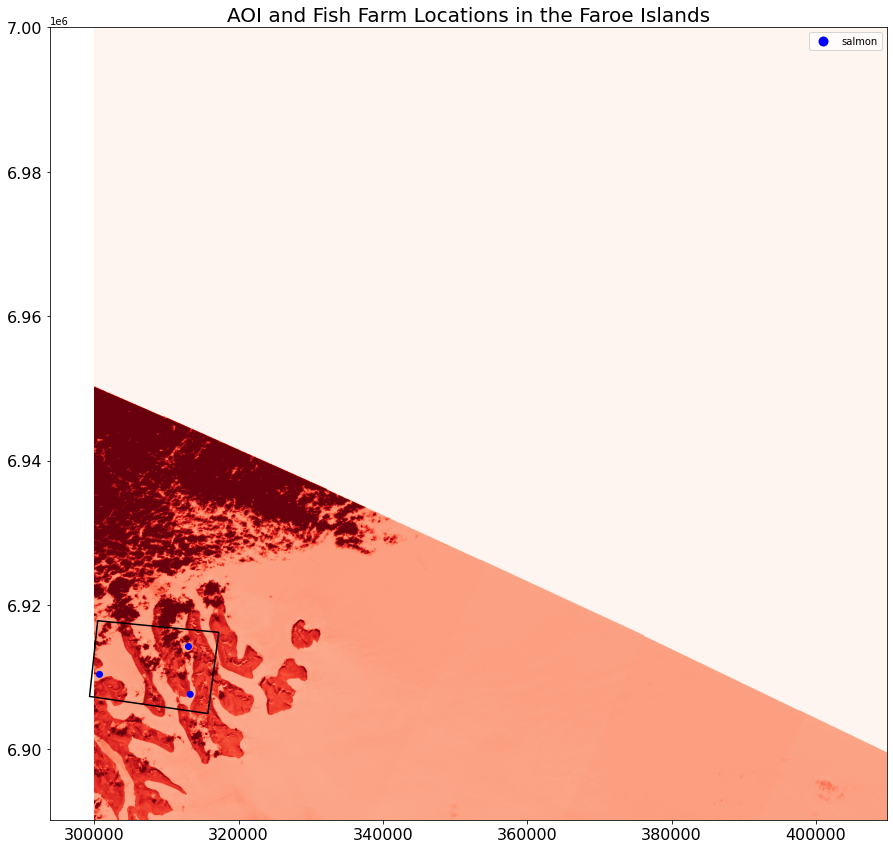

In [51]:
fig, ax_band = plt.subplots(figsize=(15, 15))

# plot raster with rasterio
show(normalise_band(band_img), transform=band_metadata['transform'], ax=ax_band, cmap="Reds")

# create colour map so we can specify the color of the fish farm points
from matplotlib.colors import LinearSegmentedColormap
clist = [(0.0, 0.0, 1.0), (0.0, 0.0, 1.0)] # use same colour twice (rgb blue) to get a single colour
cmap = LinearSegmentedColormap.from_list(name='single_cmap', colors=clist, N=1)

# plot vector layers on top
aoi.boundary.plot(ax=ax_band, edgecolor="Black")
fish_farm_pts.plot(ax=ax_band, column="fish", cmap=cmap, legend=True)

# other plot parameters
ax_band.tick_params(axis='both', which='major', labelsize=16)
ax_band.set_title('AOI and Fish Farm Locations in the Faroe Islands', fontsize=20)

plt.show()

### Extract pixels within polygons - Zonal Statistics

Often we have multiple areas of interest defined by polygons where we would like to use to analyse many satellite rasters. We can calculate group properties using zonal statistics.

We can use the `rasterstats` package to do this.

In [34]:
from rasterstats import zonal_stats

# calculate statistics
statistics = zonal_stats(aoi, band_img, affine=band_metadata['transform'], nodata=-9999, stats='mean min max std', geojson_out=True)

# The geojson_out=True means the dictionary is output with the geometry
# Therefore we can reconstruct the GDF as below
aoi_with_statistics = gpd.GeoDataFrame.from_features(statistics, crs=aoi.crs)

print(aoi_with_statistics)

                                            geometry                Name  \
0  POLYGON ((317258.354 6916193.076, 300476.623 6...  Faroe Salmon Farms   

      min      max         mean         std  
0  1005.0  55537.0  2760.069481  5647.88272  


### Mask raster to polygon